# UK Car Sales: Data Preprocessing

__________________________
**Tags:** *Machine Learning*, *Data Preprocessing*, *Data Visualization*

**Techniques**: *Custom Feature Transformers*, *Data Pipelines*

**Python:** *pandas*, *scikit-learn*, *seaborn*
__________________________

### Relevant packages used throughout this notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

<p> <br> </p>
<p> <br> </p>
<p> <br> </p>
<p> <br> </p>
<p> <br> </p>

__________________________
# 1. Importing Data

The following code imports the aggregated CSV file which it assumes to be stored in the current working directory.

In [2]:
import_path = os.getcwd() + "/all_cars.csv"
df_cars = pd.read_csv(import_path)
df_cars.shape

(108540, 10)

In [3]:
df_cars.head()

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,audi,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4
1,audi,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0
2,audi,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4
3,audi,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0
4,audi,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0


As the following line shows, we are dealing with 6 numerical and 4 categorical features.

In [4]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         108540 non-null  object 
 1   model         108540 non-null  object 
 2   year          108540 non-null  int64  
 3   price         108540 non-null  int64  
 4   transmission  108540 non-null  object 
 5   mileage       108540 non-null  int64  
 6   fuelType      108540 non-null  object 
 7   tax           99187 non-null   float64
 8   mpg           99187 non-null   float64
 9   engineSize    108540 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 8.3+ MB


### Ensuring reproducibility

In [5]:
rng = np.random.RandomState(314)

### Creating training and test set

In [6]:
df_train, df_test = train_test_split(df_cars, test_size=0.1, random_state=rng)

<p> <br> </p>
<p> <br> </p>
<p> <br> </p>

__________________________
# 2. Handling Categorical Data

Since there are only 4 categorical features present, let us take a quick look at the categorical training data.

In [7]:
df_train.describe(include=object)

,brand,model,transmission,fuelType
count,97686,97686,97686,97686
unique,11,195,4,5
top,ford,Focus,Manual,Petrol
freq,16202,9011,55231,53824


It should not be a problem to one-hot encode the features *brand*, *transmission* and *fuelType* as this will not create many additional features. However, encoding 195 different model types in this way is not viable. We will instead store the average sale price observed in the training data for each model in a separate column. Let us create the respective data pipelines.

### One-Hot Encoding Pipeline
**(for features *brand*, *transmission*, *fuelType*)**

In [8]:
onehot_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

### Average Model Price Transformer and Pipeline
**(for feature *model*)**

In [9]:
class AverageModelPrice(BaseEstimator, TransformerMixin):
    """
    Custom Feature Transformer. For a transformer to work with scikit-learn,
    it has to include three methods: 'fit()', 'transform()', 'fit_transform()'.    
    
    For each observed model, this transformer computes the average sale price in the given training set.
    It stores this value in a separate column called "Average Model Price" and drops the model name
    column. The respective column names must be passed when initializing a transformer object.
    
    From BaseEstimator, the methods 'get_params()' and 'set_params()' are inherited.
    From TransformerMixin, the method 'fit_transform()' is inherited.
    """
    
    def __init__(self, model_col, price_col):
        self.price_dict_ = dict() #dictionary to store learned prices
        self.model_col = model_col #name of the model column
        self.price_col = price_col #name of the price column
    
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = X.columns
        
        #collecting all model names from the training data
        self.model_list_ = X[self.model_col].unique()
        
        #adding average model prices to dictionary
        for model_name in self.model_list_:
            self.model_price_ = X[X[self.model_col] == model_name][self.price_col].mean()
            self.price_dict_[model_name] = self.model_price_
        return self
    
    def transform(self, X):
        X[self.model_col] = X[self.model_col].map(self.price_dict_).astype(float)
        return X
    
    def get_feature_names_out(self):
        return self.feature_names_in_


#Creating Transformer Instance specifying column names
avgmodprc = AverageModelPrice(model_col="model", price_col="price")

#Creating respective Pipeline
model_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("avg", avgmodprc),
    ("stdscl", StandardScaler()) 
])

<p> <br> </p>
<p> <br> </p>
<p> <br> </p>

__________________________
# 3. Handling Numerical Data

Let us now consider the remaining six numerical features. We begin by checking the price correlations of all numerical features.

In [10]:
corr_price = df_train.select_dtypes("number").corr()["price"]
np.abs(corr_price).sort_values(ascending=False)

price         1.000000
engineSize    0.630269
year          0.496978
mileage       0.426944
tax           0.307522
mpg           0.297358
Name: price, dtype: float64

Luckily, all features are at least moderately relevant for price regression, but even if this would not have been the case, we could have kept them all as there are not many features present in the first place. As the full correlation matrix shows, most of the regressors do not correlate much:

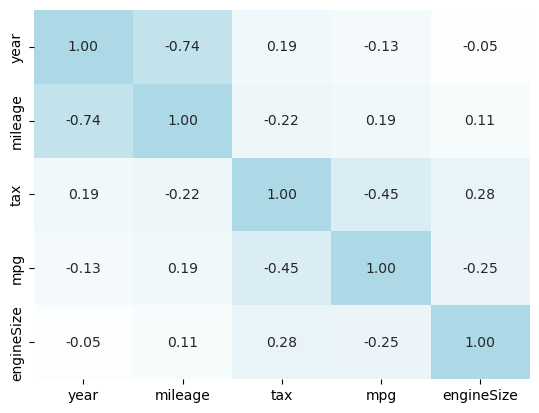

In [11]:
#create custom color map for correlation matrix
cmap = LinearSegmentedColormap.from_list('WarmCoolWarm', ['lightblue', 'white', 'lightblue'])

corrmat = df_train[["year", "mileage", "tax", "mpg", "engineSize"]].corr()
sns.heatmap(corrmat, annot=True, cmap=cmap, cbar=False, fmt='.2f', vmin=-1, vmax=1, center=0)
plt.show()

The highest correlation between numerical variables is between *mileage* and *year*, which is not surprising at all.

### Price and Mileage

As we will see below, the *price* and *mileage* features both appear to be right-skewed which is not ideal for most Machine learning algorithms.

In [12]:
#Setting general layout for seaborn plots
sns.set(style="darkgrid")
plt.rcParams["font.family"] = "Noto Sans"
title_font = {'fontsize': 13, 'fontname': 'Noto Sans'}

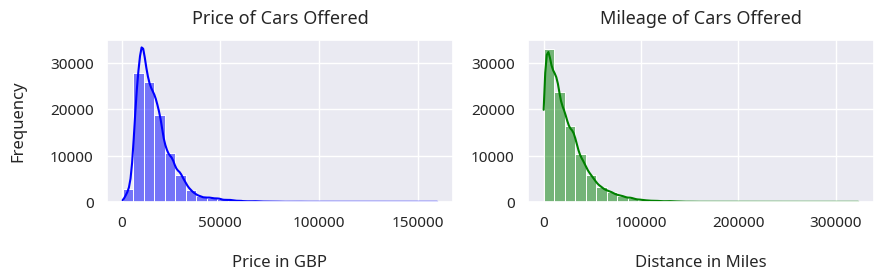

In [13]:
#Plotting price and mileage features
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.histplot(df_train["price"], bins=30, kde=True, color="blue")
plt.title("Price of Cars Offered", y=1.05, **title_font)
plt.xlabel("\nPrice in GBP")
plt.ylabel("Frequency\n")
plt.ylim(0, 35000)

plt.subplot(1, 2, 2)
sns.histplot(df_train["mileage"], bins=30, kde=True, color="green")
plt.title("Mileage of Cars Offered", y=1.05, **title_font)
plt.xlabel("\nDistance in Miles")
plt.ylabel("")
plt.ylim(0, 35000)

plt.tight_layout()
plt.show()

By trial and error, we observe that for the price, a log transformation yields a sufficiently adequate result. For the mileage, the logarithm skews the data too much to the left, so we raise it to a power $p \in (0,1)$ instead. For $p = 0.4$, the data is unskewed appropriately:

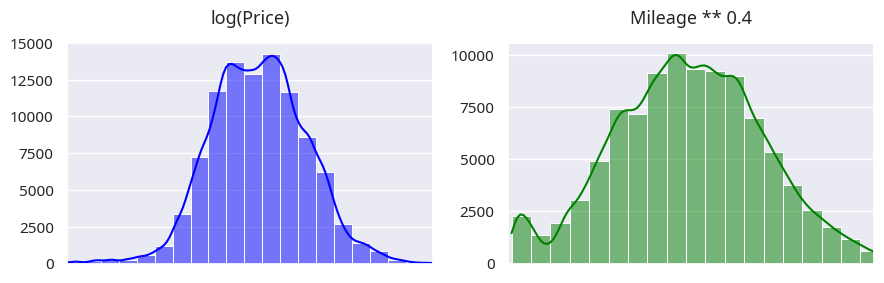

In [14]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.histplot(np.log(df_train["price"]), bins=30, kde=True, color="blue")
plt.title("log(Price)", y=1.05, **title_font)
plt.xlabel("")
plt.ylabel("")
plt.xticks(np.arange(6,13))
plt.xlim(7.5, 11.5)
plt.ylim(0, 15000)
plt.xticks([])
plt.yticks(np.arange(0,15001,2500))

plt.subplot(1, 2, 2)
sns.histplot(np.power(df_train["mileage"], 0.4), bins=30, kde=True, color="green")
plt.title("Mileage ** 0.4", y=1.05, **title_font)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.xlim(0, 100)
plt.yticks(np.arange(0,11000,2500))

plt.tight_layout()
plt.show()

In [15]:
np.log(df_train["price"]).skew(), np.power(df_train["mileage"], 0.4).skew()

(-0.13009446319180154, 0.06482321900087436)

The corresponding transformers are easy to implement, by using Scikit's *FunctionTransformer*. As we want to predict the price of the cars, it is important for the inverse function to mathematically exist and to be passed to the transformer:

In [16]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
pow_transformer = FunctionTransformer(lambda x: np.power(x, 0.4), inverse_func=lambda y: np.power(y, 2.5))

Lastly, we would like our data pipeline to impute missing values and to scale the new features to follow a standard normal distribution.

In [17]:
log_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("log", log_transformer),
    ("stdscl", StandardScaler()) 
])

pow_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("pow", pow_transformer),
    ("stdscl", StandardScaler()) 
])

### Year

Let us take a look at the age of the observed cars by plotting a histogram.

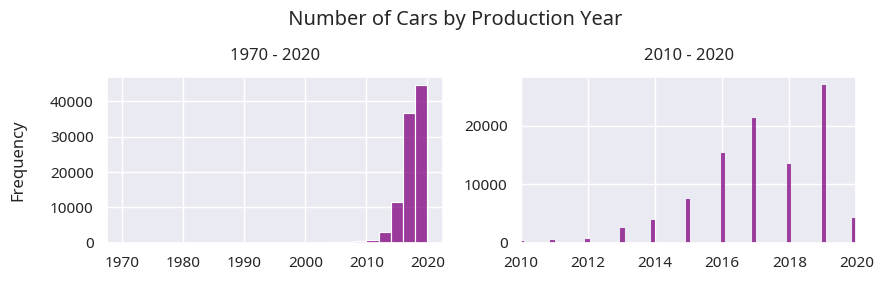

In [18]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.histplot(df_train["year"], bins=25, color="purple")
plt.suptitle("     Number of Cars by Production Year", y=0.93)
plt.title("1970 - 2020", y=1.05)
plt.xlabel("")
plt.ylabel("Frequency\n")

plt.subplot(1, 2, 2)
sns.histplot(df_train["year"], color="purple")
plt.title("2010 - 2020", y=1.05)
plt.xlabel("")
plt.ylabel("")
plt.xlim(2010,2020)

plt.tight_layout()
plt.show()

(Note that in the left plot, the years are grouped in two, so the bars on the left correspond to the sum of two consecutive year values (e.g. 2019 and 2020), which is why the first plot reaches higher values than the right one.)

We can observe that the majority of cars are at most ten years old (the data has been collected in 2020). How does the age of the car influence its price on the market? A boxenplot can give us valuable insights. What we might have expected is that older cars are generally worth less. Additionally, we can see that there is a sharp drop in value after one year and again after two years. The subsequent drops in value are not as consequential. After six years of age (year 2014 and before), not only are there few cars left (about 9.0 %), but there is also not much value left to lose, as the following graph reveals:

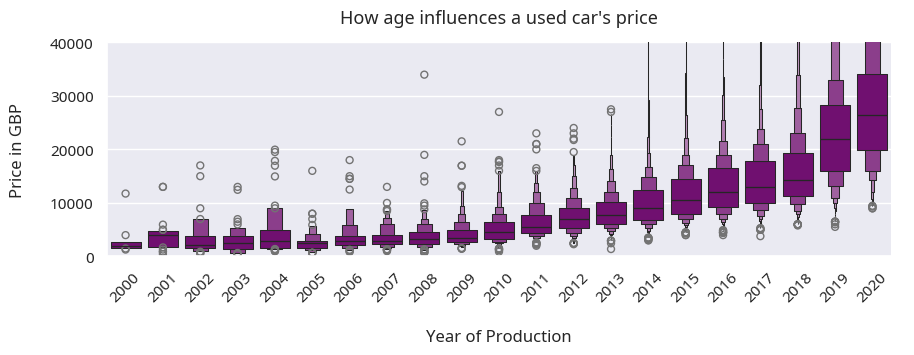

In [19]:
young_cars = df_train[df_train["year"] >= 2000]

sns.catplot(data=young_cars, y="price", x="year", color="purple", kind="boxen", 
                height=3, aspect=3)

plt.title("How age influences a used car's price", y=1.05, **title_font)
plt.xticks(rotation=45)
plt.xlabel("\nYear of Production")
plt.ylabel("Price in GBP\n")
plt.ylim(0,40000)
plt.show()

For these reasons, it makes sense to keep the high values of the *year* feature as they are. On the other hand, it should not matter exactly how old a car is beyond a certain age. Hence we create a transformer that places all values below 2014 into the same bin. By translating the data to an interval starting from zero, we rescale it into a suitable range for further purposes.

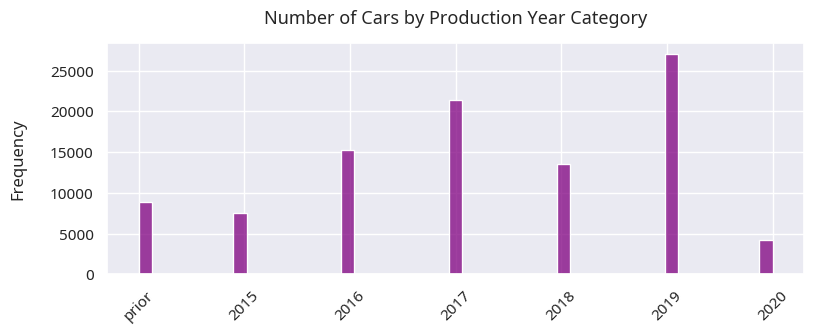

In [20]:
year_transformer = FunctionTransformer(lambda x: np.maximum(2014, x) - 2014)
year_tf = year_transformer.transform(df_train["year"])

plt.figure(figsize=(9, 3))

g = sns.histplot(year_tf, color="purple")
plt.xticks(np.arange(0,7), ["prior", 2015, 2016, 2017, 2018, 2019, 2020], rotation=45)
plt.title("Number of Cars by Production Year Category", y=1.05, **title_font)
plt.xlabel("")
plt.ylabel("Frequency\n")
plt.show()

Though it has not vanished entirely, the skew value has been diminished. A mild skew of this magnitude can be considered acceptable.

In [21]:
df_train["year"].skew(), year_tf.skew()

(-2.0564367422566527, -0.3638201002421604)

The year pipeline should also impute missing values and be scaled to a standard normal:

In [22]:
year_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("year", year_transformer),
    ("stdscl", MinMaxScaler()) 
])

### Fuel Efficiency

To mitigate skewness in the feature *mpg* which measures fuel efficiency, we proceed similarly.

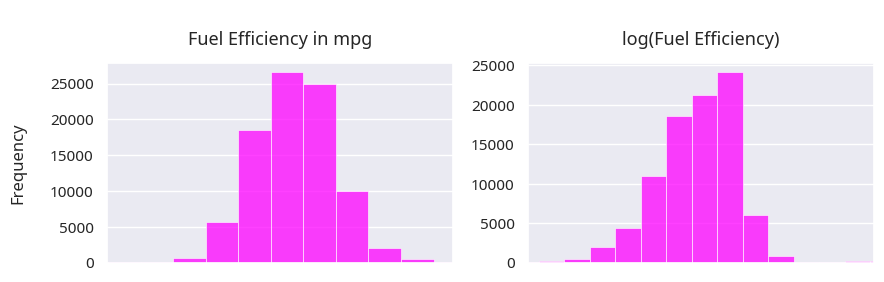

In [23]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.histplot(df_train["mpg"], bins=50, color="magenta")
plt.title("\nFuel Efficiency in mpg", y=1.05, **title_font)
plt.xlabel("")
plt.xticks([])
plt.ylabel("Frequency\n")
plt.xlim(0,100)

plt.subplot(1, 2, 2)
sns.histplot(np.log(df_train["mpg"]), bins=50, color="magenta")
plt.title("\nlog(Fuel Efficiency)", y=1.05, **title_font)
plt.xlabel("")
plt.xticks([])
plt.ylabel("")
plt.xlim(3,5)

plt.tight_layout()
plt.show()

As we can see, the data is no longer skewed as much.

In [24]:
df_train["mpg"].skew(), np.log(df_train["mpg"]).skew()

(8.904272251528933, -0.3310270970415335)

We will simply use the *log_pipeline* we created before for the fuel efficiency feature.

### Road Tax and Engine Size

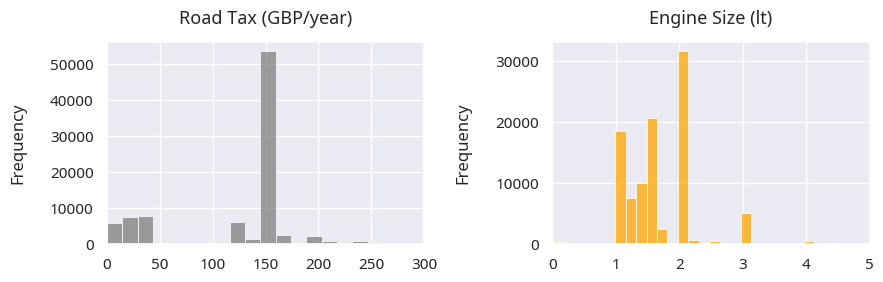

In [25]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.histplot(df_train["tax"], bins=40, color="gray")
plt.title("Road Tax (GBP/year)", y=1.05, **title_font)
plt.xlabel("")
plt.xlim(0,300)
plt.ylabel("Frequency\n")

plt.subplot(1, 2, 2)
sns.histplot(df_train["engineSize"], bins=40, color="orange")
plt.title("Engine Size (lt)", y=1.05, **title_font)
plt.xlabel("")
plt.ylabel("Frequency\n")
plt.xticks(np.arange(0,6))
plt.xlim(0,5)

plt.tight_layout()
plt.show()

Looking at the graph for the road tax, we observe that the overwhelming majority of cars has a car tax of about 150 GBP. Furthermore, there are few cars that have a very low road tax between 0 and 50. Due to the fact that car prices are typically much higher than the amount of their corresponding road tax, the exact amount of the tax should not be too critical for the price of a used car. Hence we transform the road tax feature into a binary feature by grouping its values into the ranges of $[0, 50)$ and $[50, \infty)$.

In [26]:
#returns 1 if road tax is higher than 50 GBP and 0 otherwise
def tax_transformation(X):
    new_col = (X >= 50).astype(float)
    return pd.DataFrame(new_col, columns=["tax_tf"], index=df_train.index)

binary_transformer = FunctionTransformer(tax_transformation, validate=True)

In [27]:
tax_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("bin", binary_transformer) 
])

As we know from the quick correlation analysis at the beginning of this section, engine size is the most important numerical feature when it comes to predicting the price of a car. For now, let us simply scale the range of sizes to follow a standard normal distribution.

In [28]:
engine_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("stdscl", StandardScaler()) 
])

<p> <br> </p>
<p> <br> </p>
<p> <br> </p>

__________________________
# 4. The Final Transformer

Let us put all transformations together into one single transformer.

In [29]:
preprocessing = ColumnTransformer([
    #converting tax values to categorical feature
    ("tax", tax_pipeline, ["tax"]),
    #imputing and scaling engine size feature
    ("engine", engine_pipeline, ["engineSize"]),    
    #converting and scaling year values
    ("year", year_pipeline, ["year"]),
    #converting mileage values to scaled feature
    ("pow", pow_pipeline, ["mileage"]),
    #converting values to scaled feature
    ("log", log_pipeline, ["mpg", "price"]),
    #default categorical pipeline
    ("cat", onehot_pipeline, ["brand", "transmission", "fuelType"]),
    #transforming categorical model feature into scaled numerical feature
    ("model", model_pipeline, ["model", "price"]),
]).set_output(transform="pandas")

In [30]:
df_tf = preprocessing.fit_transform(df_train)
df_tf.head()

,tax__tax_tf,engine__engineSize,year__year,pow__mileage,log__mpg,log__price,cat__brand_audi,cat__brand_bmw,cat__brand_cclass,cat__brand_focus,...,cat__transmission_Manual,cat__transmission_Other,cat__transmission_Semi-Auto,cat__fuelType_Diesel,cat__fuelType_Electric,cat__fuelType_Hybrid,cat__fuelType_Other,cat__fuelType_Petrol,model__model,model__price
49125,1.0,-0.110142,0.666667,-0.787709,1.651304,0.309527,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.148644,0.042631
23749,1.0,2.404640,0.666667,-0.732295,0.118237,1.839890,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.907507,2.268544
102863,0.0,-0.828651,0.333333,-0.118439,0.488685,-0.920600,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.732036,-0.808575
49064,0.0,-1.187905,0.000000,0.026492,0.488685,-1.847444,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.204008,-1.167457
54637,1.0,-0.289769,0.833333,-0.178418,-0.646855,0.582652,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.907507,0.319665


In [34]:
df_tf.to_csv("all_cars_transformed.csv", header=True)

In [31]:
"""sns.set_style("white")
g = sns.catplot(x=np.maximum(2014, df_train["year"]) - 2014, y=df_train["price"],
            hue=df_train["brand"], height=3, aspect=2)
g.legend.set_title("Car Brand")
g.set_xticklabels(np.arange(2014,2021))

plt.title("Price by Production Year and Brand", y=1.05, **title_font)
plt.xlabel("")
plt.ylabel("Price\n")
plt.yticks([])
plt.show()
"""

'sns.set_style("white")\ng = sns.catplot(x=np.maximum(2014, df_train["year"]) - 2014, y=df_train["price"],\n            hue=df_train["brand"], height=3, aspect=2)\ng.legend.set_title("Car Brand")\ng.set_xticklabels(np.arange(2014,2021))\n\nplt.title("Price by Production Year and Brand", y=1.05, **title_font)\nplt.xlabel("")\nplt.ylabel("Price\n")\nplt.yticks([])\nplt.show()\n'